In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=False)

#put the path to the directory with .csv files and 'images' folder on your google drive
datapath = '/content/drive/My Drive/ai-side-projects/road_segmentation/cityscapes_data/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Loading  [Cityscapes Image Pairs](https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data#) kaggle dataset, [source](https://www.cityscapes-dataset.com)

Parts of code are from my projects or [this notebook](https://www.kaggle.com/code/tr1gg3rtrash/car-driving-segmentation-unet-from-scratch/notebook), or standatd tutorials.

My goal is to make a road detection network.

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import cv2


# Data preparation and road mask selection

## Road mask with color filtering


Original segmentation map is not very useful since it has different possible colors for a given class (e.g. `road` is marked with magenta, but  do **not** have a constant color code).

Initial approach is to select a possible range of colors of `road` class colors and make a mask from it, but it is very noisy (see the first mask below).

I opted to smooth the mask image first and then make a magenta color mask and the image is smoother.  The resulted mask is much more continuous, but edge effects can be seen. So far I ignore it.

In [3]:
def filter_road_colors(img):
  # Define the range of RGB values for roads
  road_color_lower = np.array([110, 50, 120])
  road_color_upper = np.array([130, 70, 130])

  road_mask = np.all((img >= road_color_lower) & (img <= road_color_upper), axis=-1)

  road_mask = road_mask.astype(np.uint8) * 255

  return road_mask


def preprocess(path, smoothing_scale = 10, resize = 128):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256))
    img2 = img.crop((256, 0, 512, 256))
    if resize:
      img1 = img1.resize((resize,resize))
      img2 = img2.resize((resize,resize))

    img1 = np.array(img1) / 255.
    img2 = np.array(img2)

    mask2 = filter_road_colors(img2)

    if smoothing_scale:
      kernel = np.ones((smoothing_scale,smoothing_scale),np.float32)/smoothing_scale**2
      img2_smoothed = cv2.filter2D(img2,-1,kernel)
      mask2_smoothed = filter_road_colors(img2_smoothed)
    else:
      img2_smoothed = img2
      mask2_smoothed = mask2

    return img1, img2, mask2, mask2_smoothed

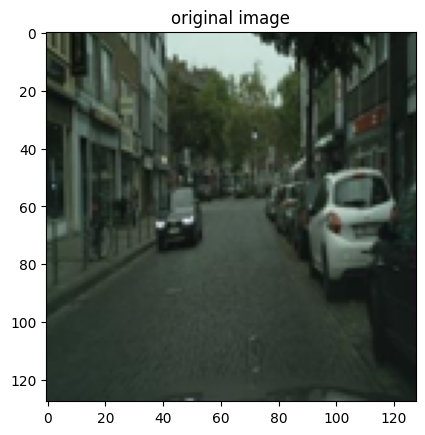

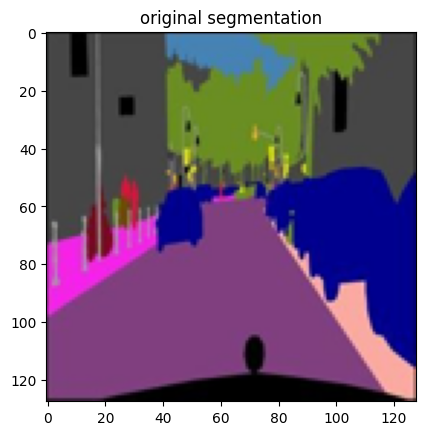

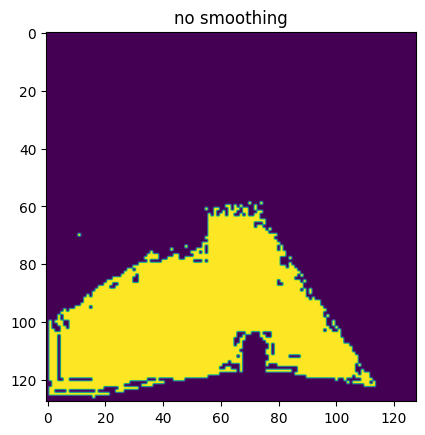

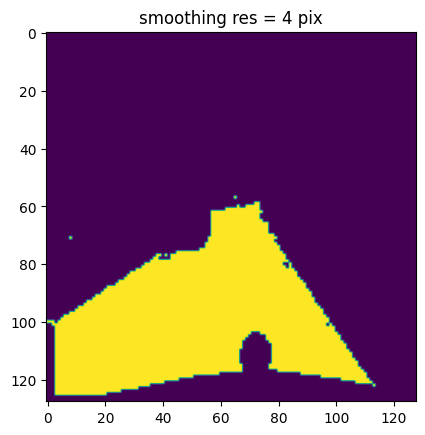

In [4]:
smooth_scale = 4
resize = 128
img1, img2, mask2, mask2_smoothed = preprocess(datapath+'train/100.jpg', smoothing_scale=smooth_scale, resize = resize)

plt.figure()
plt.imshow(img1)
plt.title('original image')
plt.figure()
plt.imshow(img2)
plt.title('original segmentation')


plt.figure()
plt.imshow(mask2)
plt.title('no smoothing')
plt.figure()
plt.title(f'smoothing res = {smooth_scale} pix')
plt.imshow(mask2_smoothed)




# Data loaders

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import numpy as np
import cv2
from PIL import Image
import torch
#torch.set_default_dtype(torch.float64) #had a lot of problems with this... e.g. https://github.com/pytorch/pytorch/issues/113758

class ImageData(Dataset):
    def __init__(self, file_paths, resize=128, smooth=4):
        self.file_paths = file_paths
        self.resize = resize
        self.smooth = smooth
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Lambda(lambda x: x.permute(2, 0, 1))  # Swap dimensions to have channel first
        ])

    def __len__(self):
        return len(self.file_paths)

    def filter_road_colors(self, img):
        # Define the range of RGB values for roads
        road_color_lower = np.array([110, 50, 120])
        road_color_upper = np.array([130, 70, 130])

        road_mask = np.all((img >= road_color_lower) & (img <= road_color_upper), axis=-1)

        road_mask = road_mask.astype(np.uint8)

        return road_mask

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = Image.open(file_path)
        img1 = img.crop((0, 0, 256, 256))
        img2 = img.crop((256, 0, 512, 256))

        if self.resize:
            img1 = img1.resize((self.resize, self.resize))
            img2 = img2.resize((self.resize, self.resize))

        img1 = np.array(img1) / 255.
        img2 = np.array(img2)

        mask = self.filter_road_colors(img2)

        if self.smooth:
            kernel = np.ones((self.smooth, self.smooth), np.float32) / self.smooth ** 2
            img2_smoothed = cv2.filter2D(img2, -1, kernel)
            mask_smoothed = self.filter_road_colors(img2_smoothed)
        else:
            img2_smoothed = img2
            mask_smoothed = mask

        img1 = self.transform(img1)
        mask_smoothed = torch.tensor(mask_smoothed, dtype=torch.float32)  # Convert to tensor
        mask_smoothed = mask_smoothed.unsqueeze(0)

        #return img1, mask_smoothed
        #return img1.double(), mask_smoothed.double()
        return img1.float(), mask_smoothed.float()

# Assuming you have lists of file paths for training and validation sets
train_file_paths = [os.path.join(datapath, 'train', filename) for filename in os.listdir(os.path.join(datapath, 'train'))]
val_file_paths = [os.path.join(datapath, 'val', filename) for filename in os.listdir(os.path.join(datapath, 'val'))]


In [6]:
RESIZE = 128
SMOOTH = 4
BATCH_SIZE = 25



# Create datasets
train_dataset = ImageData(train_file_paths, resize = RESIZE, smooth = SMOOTH)
val_dataset = ImageData(val_file_paths, resize = RESIZE, smooth = SMOOTH)

# You can create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

#train_loader_iter = iter(train_loader)
#val_loader_iter = iter(val_loader)

In [7]:
[train_dataset[1][i].shape for i in [0,1]]

[torch.Size([3, 128, 128]), torch.Size([1, 128, 128])]

In [8]:
# sanity check
test_batch = next(iter(train_loader))[0], next(iter(train_loader))[1]
images, masks = test_batch
images.shape, masks.shape

(torch.Size([25, 3, 128, 128]), torch.Size([25, 1, 128, 128]))

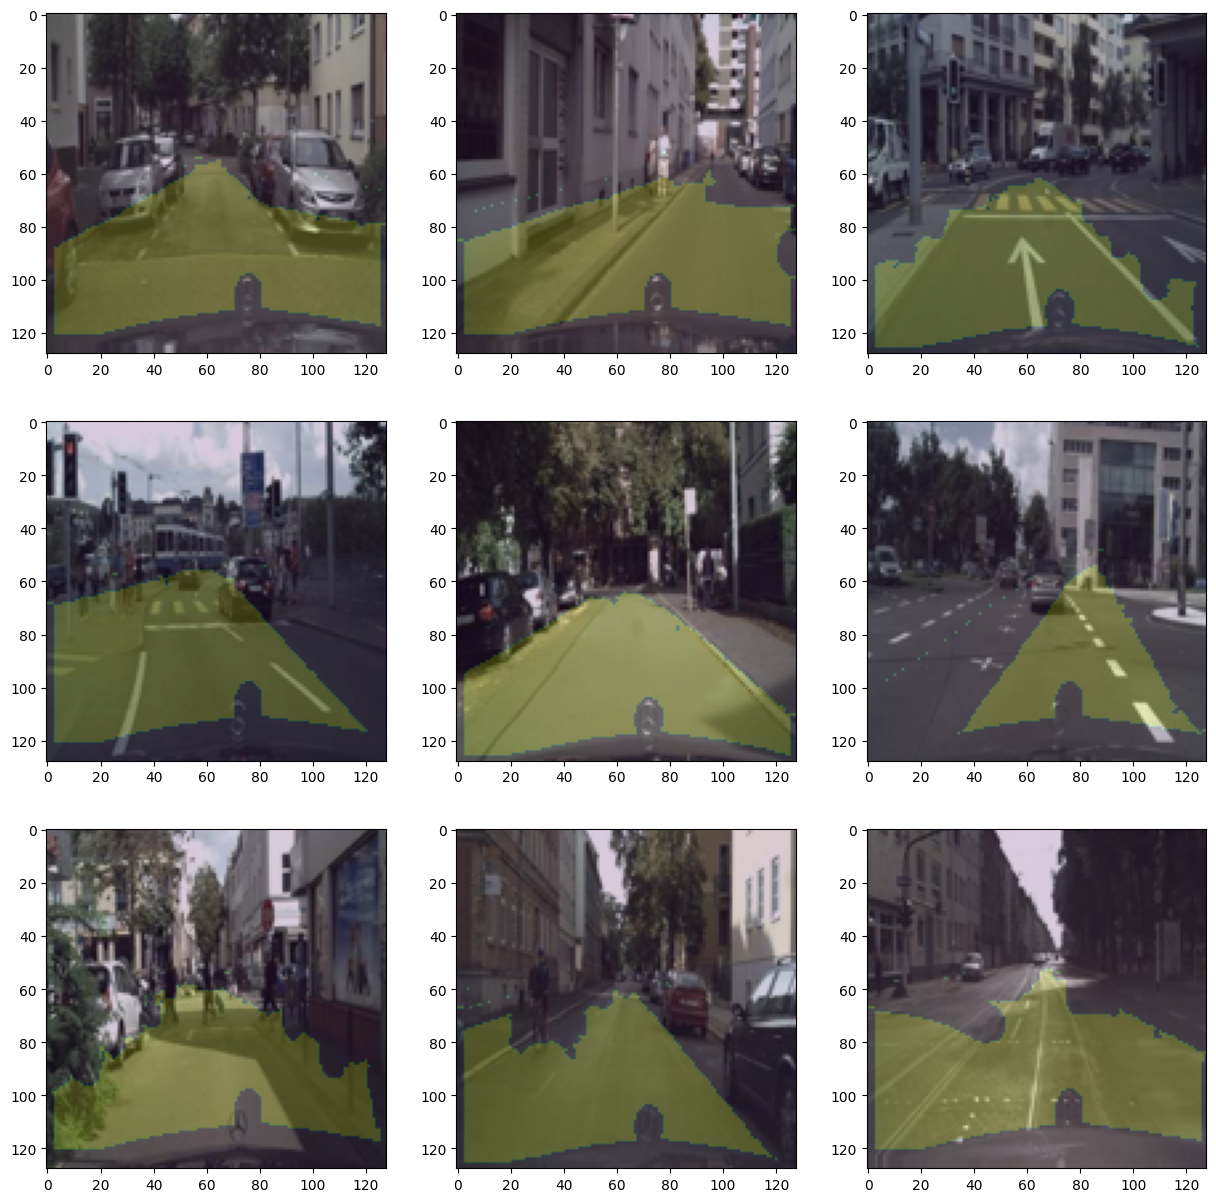

In [9]:
def show_batch(whole_batch, sqrtn = 3):
    lim = sqrtn**2
    images, label = whole_batch[0][:lim], whole_batch[1][:lim]
    images = images.numpy()
    label = label.numpy()
    fig, axs = plt.subplots(sqrtn, sqrtn, figsize = (15, 15))
    axs = axs.flatten()
    for i in range(lim):
        img_channel_last = np.transpose(images[i], (1, 2, 0))
        label_channel_last = np.transpose(label[i], (1, 2, 0))
        axs[i].imshow(img_channel_last)
        axs[i].imshow(label_channel_last, alpha = 0.2)
show_batch(test_batch)


# U-net Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


-----
new unet from [this blogpost](https://amaarora.github.io/posts/2020-09-13-unet.html)

In [11]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 'same')
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 'same')

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

enc_block = Block(1, 64)
x         = torch.randn(1, 1, 128, 128)
print('downsampling block shape test: \n', enc_block(x).shape)



class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

encoder = Encoder()
# input image
x    = torch.randn(1, 3, 128, 128)
ftrs = encoder(x)
print('encoder shapes test: ')

for ftr in ftrs: print('\t', ftr.shape)



class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = encoder_features[i]
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x



decoder = Decoder()
x = torch.randn(1, 256, 32, 32)
print('decoder shapes test : \n',decoder(x, ftrs[::-1][1:]).shape)


downsampling block shape test: 
 torch.Size([1, 64, 128, 128])
encoder shapes test: 
	 torch.Size([1, 64, 128, 128])
	 torch.Size([1, 128, 64, 64])
	 torch.Size([1, 256, 32, 32])
decoder shapes test : 
 torch.Size([1, 64, 128, 128])


In [12]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256), dec_chs=(256, 128, 64), num_class=1, out_sz=(128,128)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.double()

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)

        return out

#unet = UNet(enc_chs=(3,64,128,256), dec_chs=(256, 128, 64))
unet = UNet(enc_chs=(3, 16, 32), dec_chs=(32, 16))
unet = unet.to(device)
x    = torch.randn(1, 3, 128, 128).type(torch.cuda.DoubleTensor).to(device)
print('unet shapes test : \n', unet(x).shape)

unet shapes test : 
 torch.Size([1, 1, 128, 128])


In [13]:
import time

t0 = time.time()
test_batch_pred = unet(test_batch[0].type(torch.cuda.DoubleTensor).to(device))
t1 = time.time()
print('unet shape test on real data: \n', test_batch_pred.shape)
print('inference time for this batch (ms): ', 1000*(t1-t0))

unet shape test on real data: 
 torch.Size([25, 1, 128, 128])
inference time for this batch (ms):  348.0854034423828


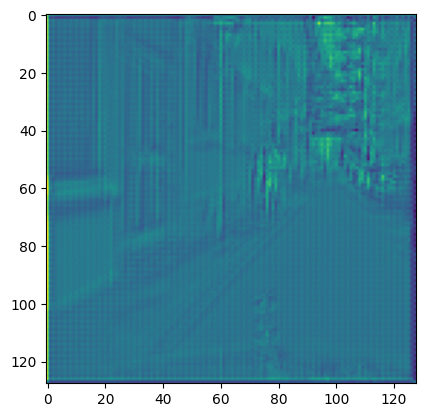

In [14]:
plt.imshow(test_batch_pred[1].cpu().detach().numpy()[0])

In [15]:

optimizer = torch.optim.Adam(params = unet.parameters(),
                             lr=1e-4)
loss_fn = nn.BCELoss()


EPOCHS = 5

In [16]:
history = dict(train_loss = [],
               val_loss = [],
               train_acc = [],
               val_acc = [])

In [17]:
track_runtime = False
for i in range(EPOCHS):

    trainloss = 0
    valloss = 0

    for img,label in tqdm(train_loader):

        optimizer.zero_grad()
        img = img.type(torch.cuda.DoubleTensor)
        label = label.type(torch.cuda.DoubleTensor)
        img = img.to(device)
        label = label.to(device)


        t0 = time.time()
        output = unet(img)
        t1 = time.time()
        if track_runtime: print('inference time (ms): ', 1000*(t1-t0))

        t0 = time.time()
        loss = loss_fn(output,label)
        t1 = time.time()
        if track_runtime: print('loss function calc time (ms): ', 1000*(t1-t0))

        t0 = time.time()
        loss.backward()
        t1 = time.time()
        if track_runtime: print('backprop time (ms): ', 1000*(t1-t0))


        t0 = time.time()
        optimizer.step()
        t1 = time.time()
        if track_runtime: print('optimizer step time (ms): ', 1000*(t1-t0))


        t0 = time.time()
        trainloss+=loss.item()
        t1 = time.time()
        if track_runtime: print('loss item picking time (ms): ', 1000*(t1-t0))


    history['train_loss'].append(trainloss/len(train_loader))
    #history['train_loss'].append(None)

    for img,label in tqdm(val_loader):
          '''
              Validation of Model.
          '''
          img = img.type(torch.cuda.DoubleTensor)
          label = label.type(torch.cuda.DoubleTensor)
          img = img.to(device)
          label = label.to(device)
          output = unet(img)
          loss = loss_fn(output,label)
          valloss+=loss.item()

    history['val_loss'].append(valloss/len(val_loader))
    #history['val_loss'].append(None)

    print(f"epoch : {i} ,train loss : {history['train_loss'][-1]} ,valid loss : {history['val_loss'][-1]} ")


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


epoch : 0 ,train loss : 0.657040623817715 ,valid loss : 0.5924839052251196 


100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


epoch : 1 ,train loss : 0.5723761347659705 ,valid loss : 0.5487709424126667 


  4%|▎         | 2/54 [00:01<00:51,  1.01it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


**QUESTION**: Error such as
```
RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

```
periodically pops up,  I guess due to the float precosion I use.